In [16]:
import pandas as pd
import numpy as np
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score

import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import cross_validation, metrics
from sklearn.grid_search import GridSearchCV

import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams

In [17]:
train_data = pd.read_csv('../data/titanic_train.csv')
test_data = pd.read_csv('../data/titanic_test.csv')

test_data['Survived'] = 0
test_data['Test'] = False
train_data['Test'] = True

In [18]:
train_data.head(1)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Test
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.25,NaN,S,True


In [19]:
all_data = pd.concat([train_data, test_data])
all_data.shape

(1309, 13)

In [20]:
all_data.columns

Index([u'Age', u'Cabin', u'Embarked', u'Fare', u'Name', u'Parch',
       u'PassengerId', u'Pclass', u'Sex', u'SibSp', u'Survived', u'Test',
       u'Ticket'],
      dtype='object')

In [21]:
numeric_columns = ['Age', 'Pclass', 'Fare', 'Parch', 'SibSp', 'Sex']
categorical_columns = ['Embarked']
drop_columns = ['Name', 'Cabin']

In [22]:
all_data = all_data.drop(drop_columns)
all_data[all_data['Test']].dropna(inplace=True)

D:\soft\dev\anaconda\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


### Test on raw data

In [22]:
train_data.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
Test             0
dtype: int64

In [23]:
train_data['Age'][train_data['Age'].isnull()] = train_data['Age'].median()
train_data['Cabin'][train_data['Cabin'].isnull()] = 'NA'
train_data['Embarked'][train_data['Embarked'].isnull()] = 'S'
train_data.iloc()

D:\soft\dev\anaconda\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
D:\soft\dev\anaconda\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
D:\soft\dev\anaconda\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [24]:
train_data.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
Test           0
dtype: int64

In [28]:
train_data.dropna(inplace=True)

In [29]:
train_data.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
Test              bool
dtype: object

In [32]:
numeric = train_data[numeric_columns]
numeric['Sex'] = numeric['Sex'].apply(lambda it: it == 'male')
categ = train_data[categorical_columns]
categ = pd.get_dummies(categ)

xgb_data = pd.concat([numeric, categ], axis=1)
target = train_data['Survived']

data_train, data_test, target_train, target_test = train_test_split(
    xgb_data, target, test_size=0.2, random_state=42)

dtrain = pd.concat([data_train, target_train], axis=1)

D:\soft\dev\anaconda\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [33]:
xgb_data.dtypes

Age           float64
Pclass          int64
Fare          float64
Parch           int64
SibSp           int64
Sex              bool
Embarked_C    float64
Embarked_Q    float64
Embarked_S    float64
dtype: object

In [34]:
xgb1 = XGBClassifier()

xgb1.fit(data_train, target_train, eval_metric='auc')
accuracy_score(xgb1.predict(data_test), target_test)

0.81005586592178769


Model Report
Accuracy : 0.8947
AUC Score (Train): 0.948732


0.84916201117318435

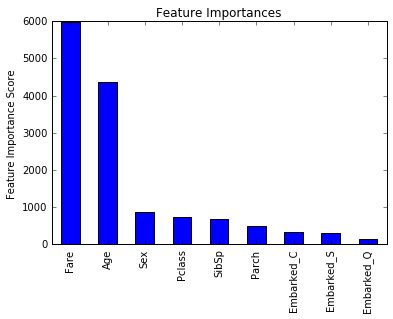

In [68]:
xgb2 = XGBClassifier(
    learning_rate=0.01,
    n_estimators=5000,
    max_depth=2,
    min_child_weight=3,
    gamma=0.0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='binary:logistic',
    nthread=4,
    scale_pos_weight=1,
    seed=42)


target_col = 'Survived'
predictor_cols = dtrain.columns.drop(target_col)
alg = xgb2
useTrainCV = False
cv_folds = 5
early_stopping_rounds = 50

if useTrainCV:
    xgb_param = alg.get_xgb_params()
    xgtrain = xgb.DMatrix(dtrain[predictor_cols].values, label=dtrain[target_col].values)
    cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
        metrics='auc', early_stopping_rounds=early_stopping_rounds)
    alg.set_params(n_estimators=cvresult.shape[0])

#Fit the algorithm on the data
alg.fit(dtrain[predictor_cols], dtrain[target_col], eval_metric='auc')

#Predict training set:
dtrain_predictions = alg.predict(dtrain[predictor_cols])
dtrain_predprob = alg.predict_proba(dtrain[predictor_cols])[:,1]

#Print model report:
print "\nModel Report"
print "Accuracy : %.4g" % metrics.accuracy_score(dtrain[target_col].values, dtrain_predictions)
print "AUC Score (Train): %f" % metrics.roc_auc_score(dtrain[target_col], dtrain_predprob)

feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

accuracy_score(alg.predict(data_test), target_test)

# 0.85474860335195535

# 2
#Model Report
#Accuracy : 0.8806
#AUC Score (Train): 0.928562
#Out[36]:
#0.83798882681564246